In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

In [45]:
class BottleNeck(nn.Module):
    '''BottleNeck
    BottleNeck은 일반적으로 ( 1 * 1 -> 3 * 3 -> 1 * 1) 형태를 지닙니다.
    그리고 in_channels, hidden_channels, expansion을 필요로 합니다.
    expansion = out_channels / hidden_channels 이며 주로 ( in_c -> hi_c -> hi_c * expansin ) 으로 채널을 구성합니다.
    '''
    global expansion
    def __init__(self, in_channels, hidden_channels, stride=2):
        super().__init__()
        expansion = 4
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels * expansion, kernel_size=1, stride=1),
            nn.BatchNorm2d(hidden_channels),
        )

        self.downsample = None
        if in_channels != hidden_channels * expansion or stride !=1 :
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels = hidden_channels * expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(hidden_channels * expansion),
            )


    def forward(self, x) :
        identity = x
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        if self.downsample is not None :
            identity = self.downsample(identity)

        return F.relu(identity + x)


In [46]:
# prev = [18]
# current = [18, 36]

def _make_branch_layer(prev, current) :
    layers = []

    for i, c_out in enumerate(current) :
        # 이전에 존재하던 해상도
        if i < len(prev) :
            c_in = prev[i]

            if c_in != c_out :
                layers.append(nn.Sequential(
                    nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
                    nn.BatchNorm2d(c_out),
                    nn.ReLU(inplace=True)
                ))
            else:
                layers.append(None)

        # 새로운 브랜치 생성
        else :
            c_in = prev[-1]
            layers.append(nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1,bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True)
            ))

    # nn.ModuleList()로 감싸줘야지 nn.Module을 상속하여 models.parameters() 혹은 .to(device) 같은 함수들을 사용할 수 있다.
    return nn.ModuleList(layers)

In [47]:
def window_partition(x, window):
    B, C, H, W = x.size()
    x = x.view(B, C, H // window, window, W // window, window)
    x = x.permute(0,2,4,3,5,1)
    x= x.contiguous().view(-1, window * window, C)
    print(f'window_parition에서 반환하는 데이터 사이즈 : {x.size()}')
    return x


In [48]:
def window_reverse(windows, window_size, H, W) :
    '''
    windows : 총 토큰의 수
    window_size : 토큰 하나의 사이즈
    H, W : 원래 이미지의 크기
    토큰 수가 64개인 경우, window_size = 256 -> 즉 ( 64 / (8 * 8 ) = 1 )
    '''
    B = int(windows.shape[0] / ( ( H // window_size ) * (W // window_size)))
    # window_parition의 반대로 다시 펼쳐준다.
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    # 이후 permuate를 통해서 원래 형태로 복원 시켜준다. ( 배치, 채널, 높이, 너비 )
    x = x.permute(0,5,1,3,2,4).contiguous().view(B,-1,H,W)
    return x




변경 전 크기 : (1200, 1200)
변경 후 크기: (256, 256)
image size : torch.Size([1, 3, 256, 256])
window_parition에서 반환하는 데이터 사이즈 : torch.Size([64, 1024, 3])


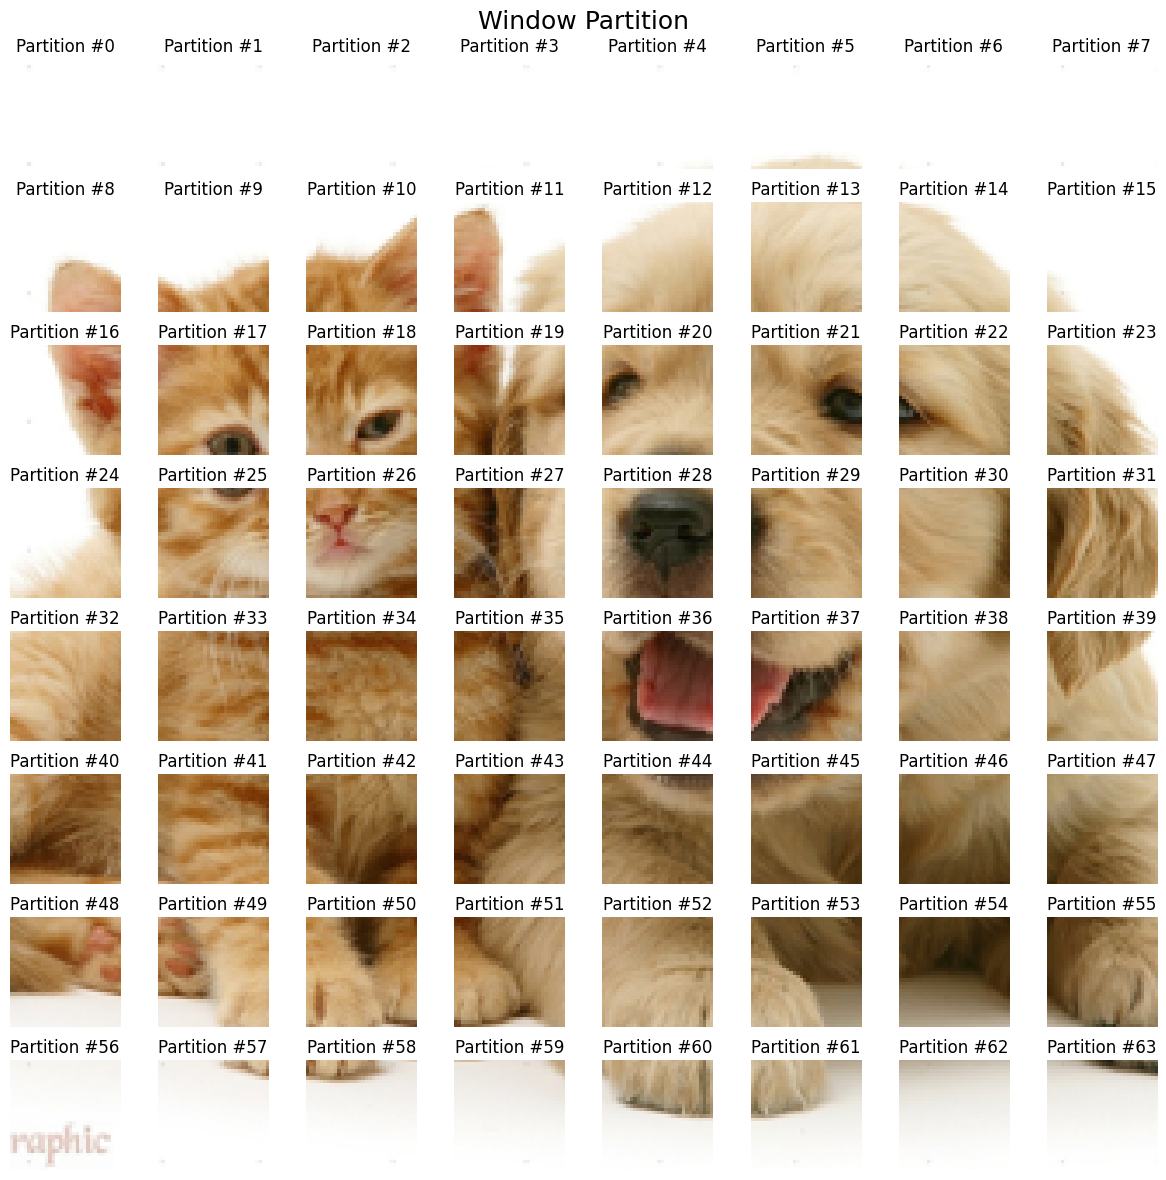

Text(0.5, 1.0, 'Window Reverse')

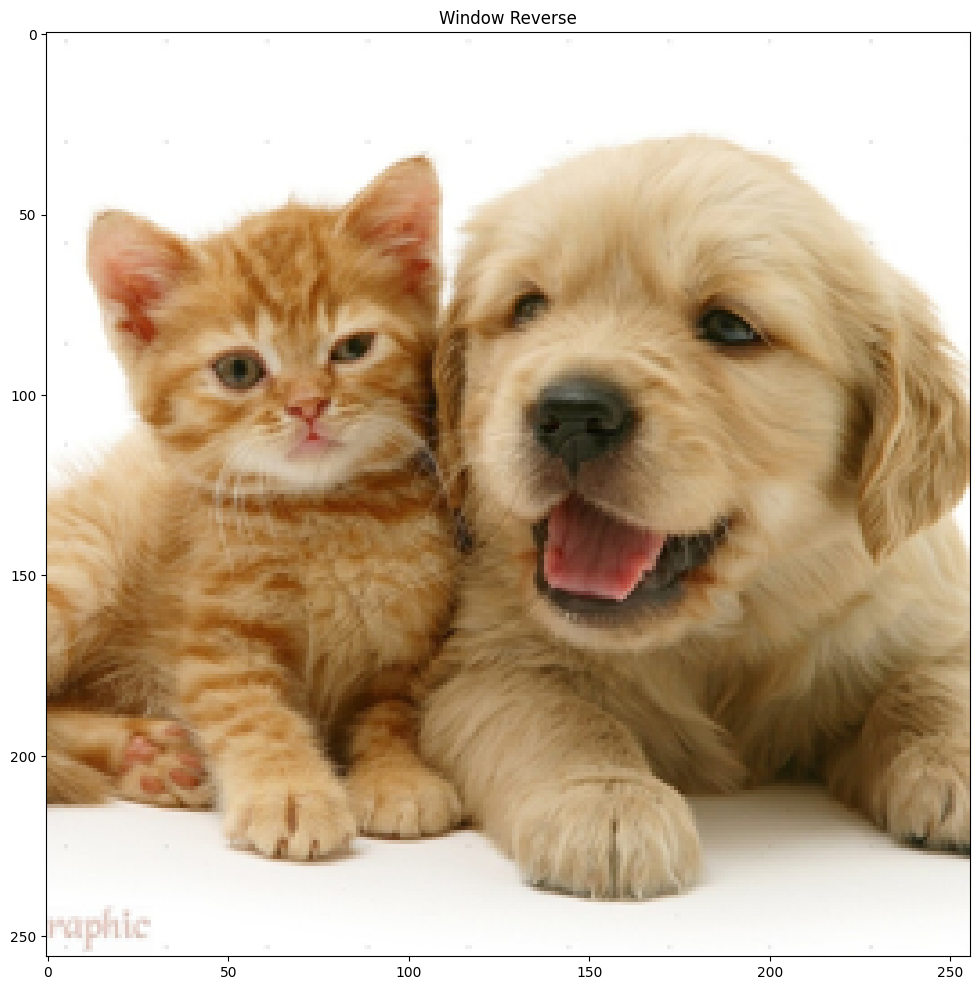

In [49]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open('/content/drive/MyDrive/cat_dog.jpg')

print(f'변경 전 크기 : {img.size}')
new_size = (256, 256)
img = img.resize((256, 256))

print('변경 후 크기:', img.size)


arr = np.array(img)
image = torch.from_numpy(arr)
image = image.unsqueeze(0).permute(0,3,1,2).float()
print(f'image size : {image.size()}')
image_size = image.size(-1)
number_patchs = 8

window_size = image.size(2) // number_patchs # 일단은 모든 이미지에 대해서 총 4개의 파티션을 나눈다는 생각

splited_window = window_partition(image, window_size)


fig, axes = plt.subplots(
    nrows=image_size // window_size,
    ncols=image_size // window_size,
    figsize=(12,12)
)

# add a title for the entire figure
fig.suptitle("Window Partition", fontsize=18)

for idx, patch in enumerate(splited_window):
    patch = patch.view(window_size, window_size, -1).cpu().numpy().astype('uint8')
    r, c = divmod(idx, number_patchs)
    ax = axes[r][c]
    ax.imshow(patch)
    ax.set_title(f"Partition #{idx}")
    ax.axis('off')

# if the suptitle overlaps the subplots, you can push them down a bit
plt.subplots_adjust(top=0.92)

plt.tight_layout()
plt.show()


image = window_reverse(splited_window, window_size, image_size, image_size)
image = image.cpu().squeeze(0).permute(1,2,0) / 255

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.imshow(image)
ax.set_title('Window Reverse')


In [50]:
class WindowAttention(nn.Module):
    def __init__(self, dim, num_head, window_size, qkv_bias=False):
        super().__init__()
        self.dim = dim
        self.num_head = num_head
        self.window_size = window_size
        self.head_dim = dim // num_head

        self.qkv = nn.Linear(self.dim, self.dim * 3, bias=qkv_bias)
        self.project = nn.Linear(self.dim, self.dim)
        self.softmax = nn.Softmax(dim = -1)
        self.scale = self.dim ** -0.5

    def forward(self, x):
        B_, N, C  = x.size()
        qkv = self.qkv(x)
        qkv = qkv.reshape(B_, N, 3, self.num_head, C // self.num_head)
        qkv = qkv.permute(2, 0, 3, 1, 4).contiguous()
        q, k, v = qkv[0], qkv[1], qkv[-1]

        attn = self.softmax( q @ k.transpose(-2,-1) * self.scale ) @ v
        x = attn.transpose(1,2)
        x = x.reshape(B_, N, C)
        x = self.project(x)

        return x


변경 전 크기 : (1200, 1200)
변경 후 크기: (256, 256)
image size : torch.Size([1, 3, 256, 256])
window_parition에서 반환하는 데이터 사이즈 : torch.Size([64, 1024, 3])
torch.Size([1024, 3])


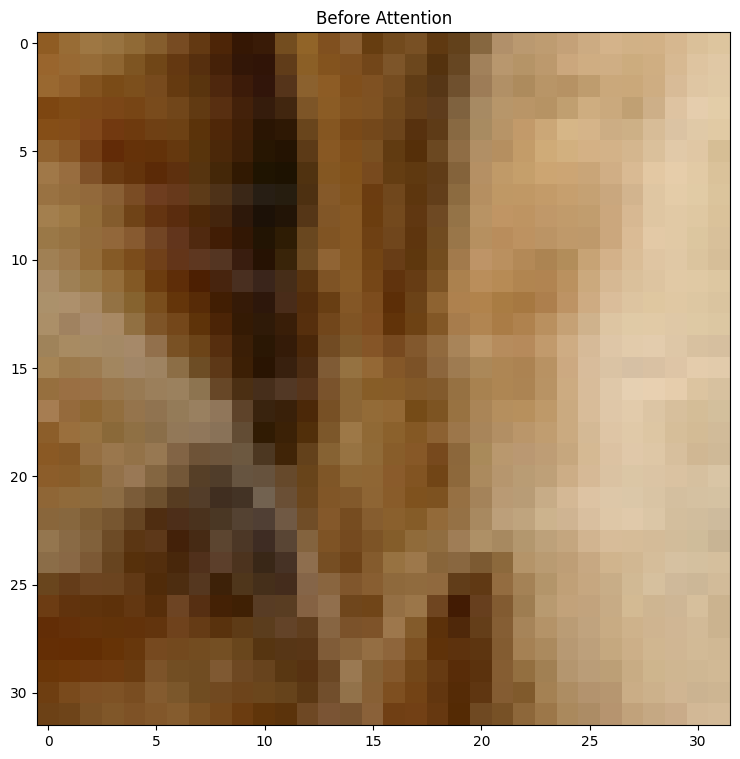

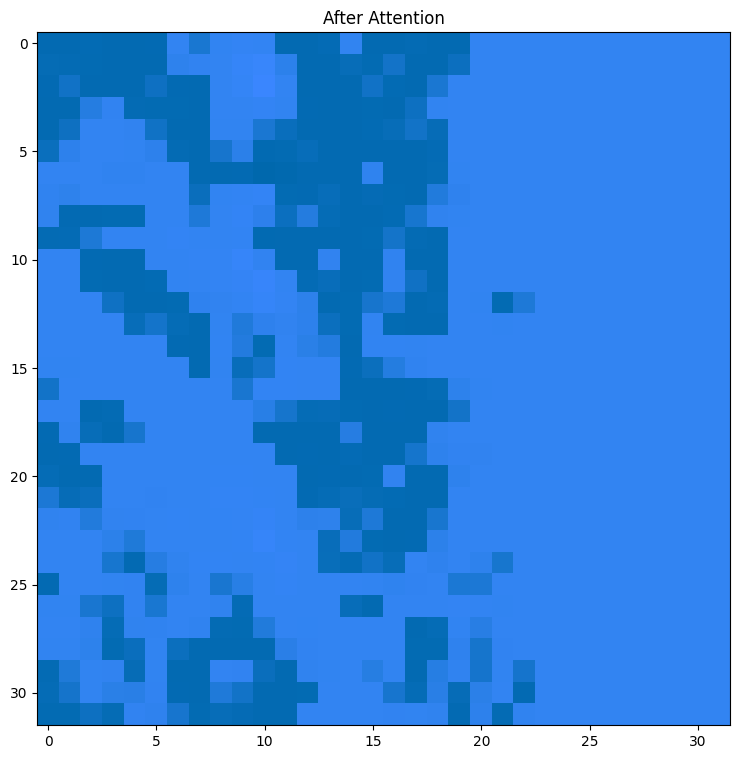

In [54]:
img = Image.open('/content/drive/MyDrive/cat_dog.jpg')

print(f'변경 전 크기 : {img.size}')
new_size = (256, 256)
img = img.resize((256, 256))

print('변경 후 크기:', img.size)


arr = np.array(img)
image = torch.from_numpy(arr)
image = image.unsqueeze(0).permute(0,3,1,2).float()
print(f'image size : {image.size()}')
image_size = image.size(-1)
number_patchs = 8

window_size = image.size(2) // number_patchs

splited_window = window_partition(image, window_size)


idx = 27
image = splited_window[idx].reshape(window_size, window_size, -1).permute(0,1,2).cpu().numpy().astype('uint8')
figure = plt.figure(figsize=(9,9))
ax = figure.add_subplot(1,1,1)
ax.set_title(f'Before Attention')
ax.imshow(image)


print(splited_window[idx].size())


# 자연스럽게 가중치가 초기화 되지 않은 모델이기 때문에 R,G,B 가 비슷하게 낮은 값을 갖고 있기에 핑크색톤으로 나오게 된다.
attention = WindowAttention(
    dim=3,
    num_head=1,
    window_size=window_size,
    qkv_bias=False
)


inp = splited_window[idx].unsqueeze(0).float()
out = attention(inp).squeeze(0)
out = out.view(window_size, window_size, 3).cpu().detach().numpy()

out = out - out.min()
out = out / (out.max() + 1e-6)
fig, ax = plt.subplots(1,1,figsize=(9,9))
ax.set_title('After Attention')
ax.imshow(out)
